In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

In [76]:
file_path = "enhanced_signal_dataset.csv"
df = pd.read_csv(file_path)

# Define input features and target variable
X = df.drop(columns=["Combinational Depth"])
y = df["Combinational Depth"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [77]:
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(640, activation='swish'),  # Increased neurons
    keras.layers.Dropout(0.4),  # Increased dropout to 0.4
    keras.layers.Dense(320, activation='swish'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(160, activation='swish'),
    keras.layers.Dense(80, activation='swish'),
    keras.layers.Dense(40, activation='swish'),
    keras.layers.Dense(1)  # Output layer
])

In [78]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for stability
              loss=keras.losses.Huber(), 
              metrics=['mae'])

# Define callbacks (Early Stopping & Reduce LR on Plateau)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=1e-7)

In [79]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4522 - mae: 0.8361 - val_loss: 0.4746 - val_mae: 0.8932 - learning_rate: 1.0000e-05
Epoch 2/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3952 - mae: 0.7639 - val_loss: 0.4682 - val_mae: 0.8859 - learning_rate: 1.0000e-05
Epoch 3/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4299 - mae: 0.8217 - val_loss: 0.4596 - val_mae: 0.8760 - learning_rate: 1.0000e-05
Epoch 4/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4012 - mae: 0.7755 - val_loss: 0.4480 - val_mae: 0.8625 - learning_rate: 1.0000e-05
Epoch 5/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3965 - mae: 0.7667 - val_loss: 0.4302 - val_mae: 0.8419 - learning_rate: 1.0000e-05
Epoch 6/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3632 - mae: 0.7321 - val_loss: 0.4043 - val_mae: 0.8112 - learning_rate: 1.0000e-05
Epoch 7/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3715 - mae: 0.7439 - val_loss: 0.3664 - val_mae:

In [80]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0270 - mae: 0.1811
Test Loss: 0.0260, Test MAE: 0.1802


In [81]:
y_pred = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [82]:
for actual, predicted in zip(y_test_inv[:5], y_pred[:5]):
    print(f"Actual: {actual[0]}, Predicted: {predicted[0]:.2f}")

Actual: 21.928655305862577, Predicted: 21.15
Actual: -4.612029808909714, Predicted: -4.34
Actual: 15.972718472747474, Predicted: 11.30
Actual: -14.662050697080844, Predicted: -13.94
Actual: 4.763553380659692, Predicted: 6.30


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

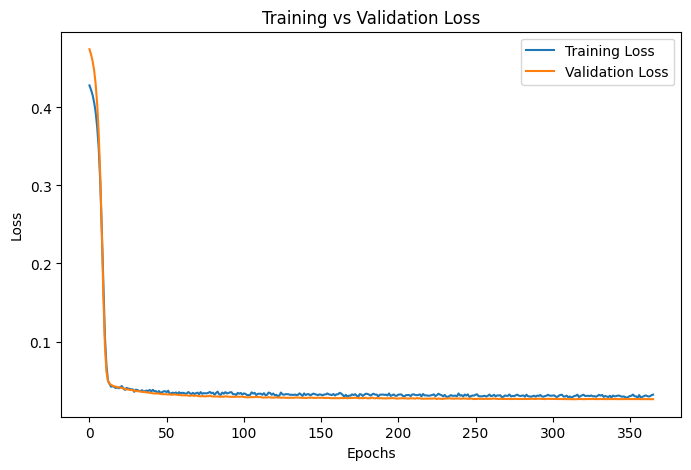

In [84]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

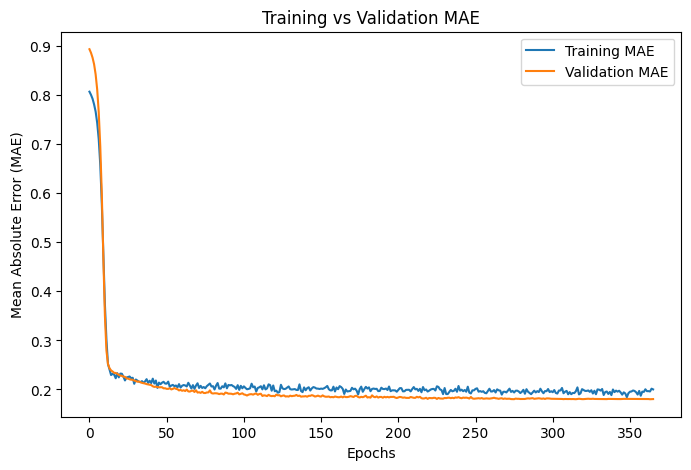

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training vs Validation MAE')
plt.legend()
plt.show()

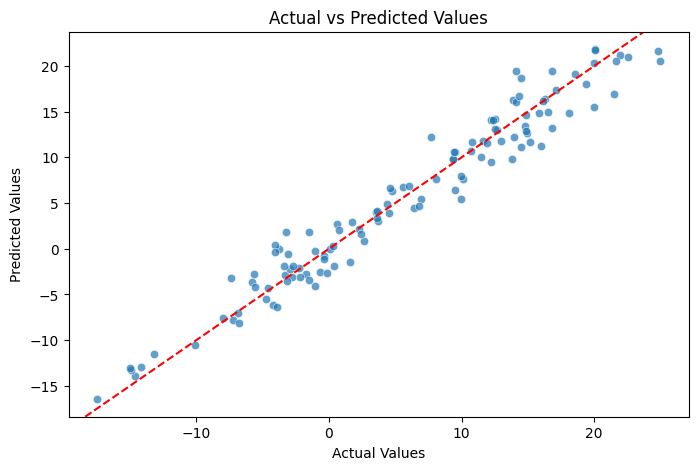

In [86]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred.flatten(), alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.axline([0, 0], slope=1, color='r', linestyle='--')  # 45-degree reference line
plt.show()

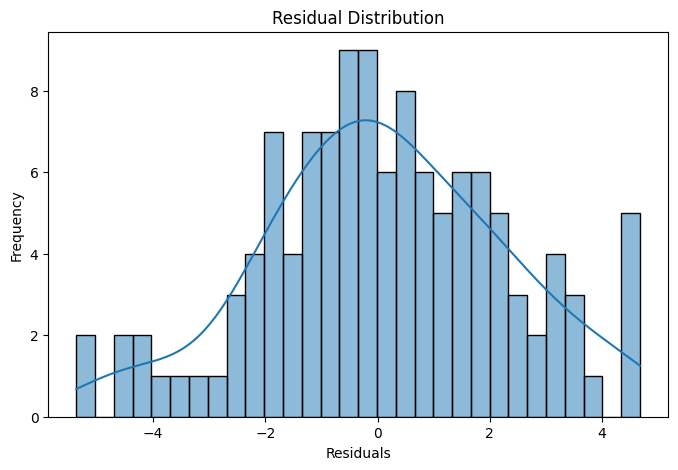

In [87]:
residuals = y_test_inv.flatten() - y_pred.flatten()
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()